In [1]:
import sys
sys.path.insert(0, "..")

from base_f import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from cross_validation_f import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from cross_validation_f import evaluate_prediction, plot_prediction, plot_anomalies
from cross_validation_f import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from cross_validation_f import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns
nb_name=''

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'
daily_input = pd.read_csv(path+nb_name[:-6]+'.csv', index_col=0, parse_dates=True)

In [4]:
daily_input

,T,T5,T25,T75,T95,E,E5,E25,E75,E95,...,P5,P25,P75,P95,S,S5,S25,S75,S95,Q
1979-01-01,268.482625,266.053328,267.780823,269.294160,271.060429,0.557991,0.369183,0.439226,0.687370,0.717020,...,0.120970,0.160236,0.340345,0.618164,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-02,262.878724,259.736764,262.067467,264.021299,266.152540,0.648914,0.414844,0.572992,0.757034,0.827345,...,0.022314,0.035593,0.099828,0.205778,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-03,266.476580,263.708992,265.765731,267.239291,269.021700,0.242404,0.124521,0.186042,0.301072,0.379569,...,0.339044,0.423442,0.827765,1.363979,0.555556,0.00,0.0,1.00,1.00,NaN
1979-01-04,270.409717,268.247576,269.549044,271.114793,272.916297,0.337283,0.260021,0.298842,0.376453,0.411988,...,6.098866,7.138765,8.896543,10.075356,8.472222,5.75,7.0,9.25,11.25,NaN
1979-01-05,270.238964,268.225210,269.179455,271.065462,273.137476,-0.031944,-0.093229,-0.055731,-0.004225,0.031144,...,0.000829,0.001296,0.004228,0.016296,8.472222,5.75,7.0,9.25,11.25,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,271.452140,269.667074,270.781875,272.195294,273.708338,0.711387,0.461368,0.612361,0.808257,0.991847,...,0.312029,0.452922,0.937131,1.334227,4.305556,0.00,2.0,4.00,12.75,17.9
2020-12-28,274.908459,272.808820,273.789467,275.820039,277.591326,0.367556,0.194956,0.286875,0.441902,0.548941,...,4.577161,5.685945,8.730686,10.344448,5.305556,0.00,0.0,7.00,17.50,17.4
2020-12-29,273.830441,271.752420,272.838365,274.665517,276.527144,0.176540,0.048795,0.123129,0.232472,0.250795,...,1.053496,1.204983,2.263973,3.479304,6.194444,0.00,0.0,9.00,20.00,16.7
2020-12-30,270.800859,268.431539,269.405724,271.904720,273.703435,-0.081323,-0.183423,-0.131987,-0.031266,0.032291,...,0.313186,0.495852,1.345617,2.338145,7.166667,0.00,1.0,10.00,21.25,15.4


In [5]:
t_unit=10

#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-2.8, 0.7, 10)
epsilon_range=np.logspace(-2.1, -1, 4)
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=4
test_size=730

Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits

C=0.34145488738336044
eps=0.007943282347242814


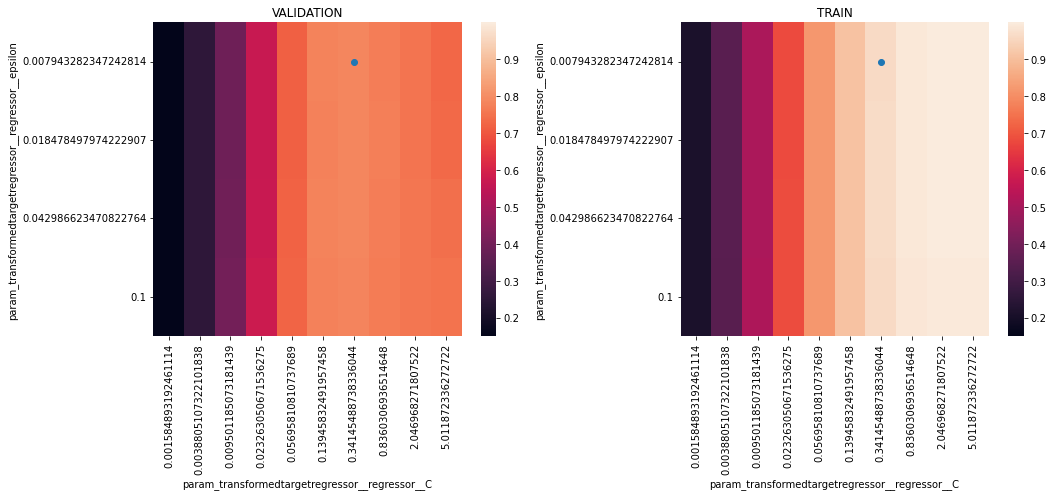

In [7]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [14]:
C_range=np.logspace(-1.4, 0.9, 5)
epsilon_range=np.logspace(-4.1, -2.1, 4)

Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits

C=0.5623413251903491
eps=0.007943282347242814


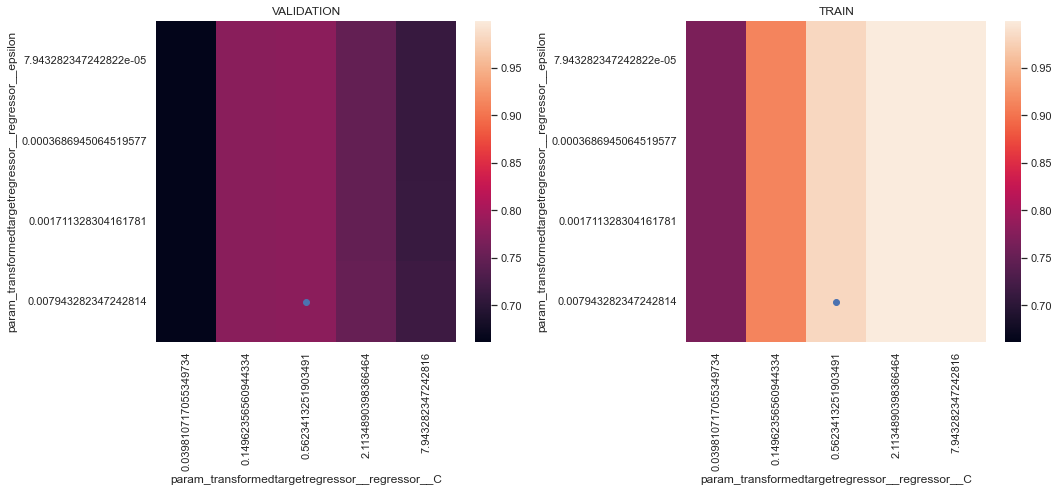

In [15]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [6]:
C=0.5623413251903491
eps=0.007943282347242814

In [7]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

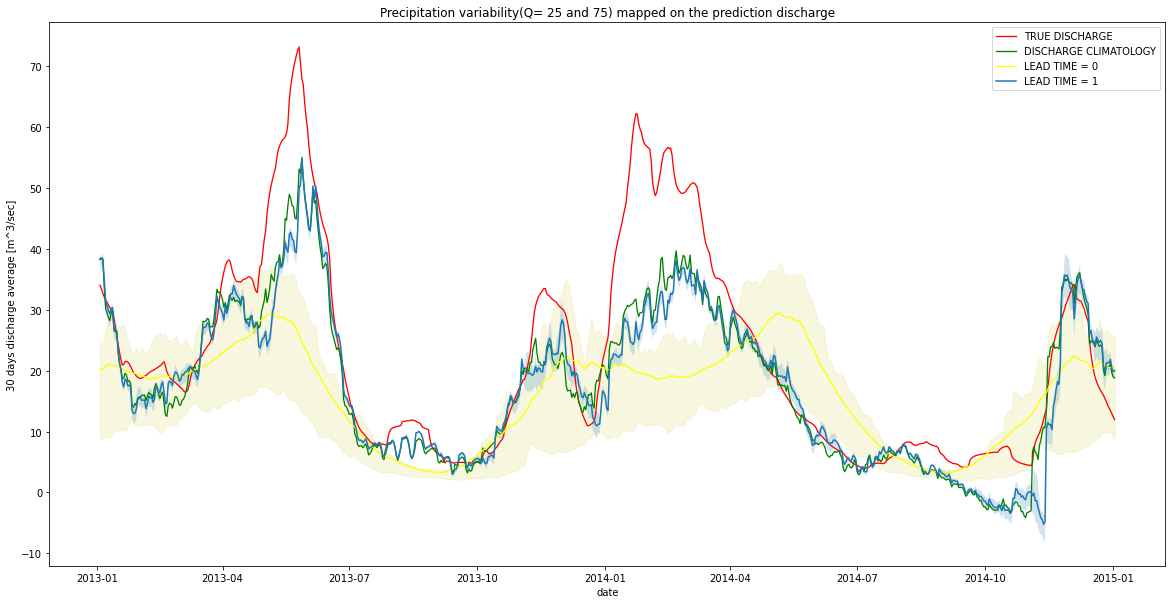

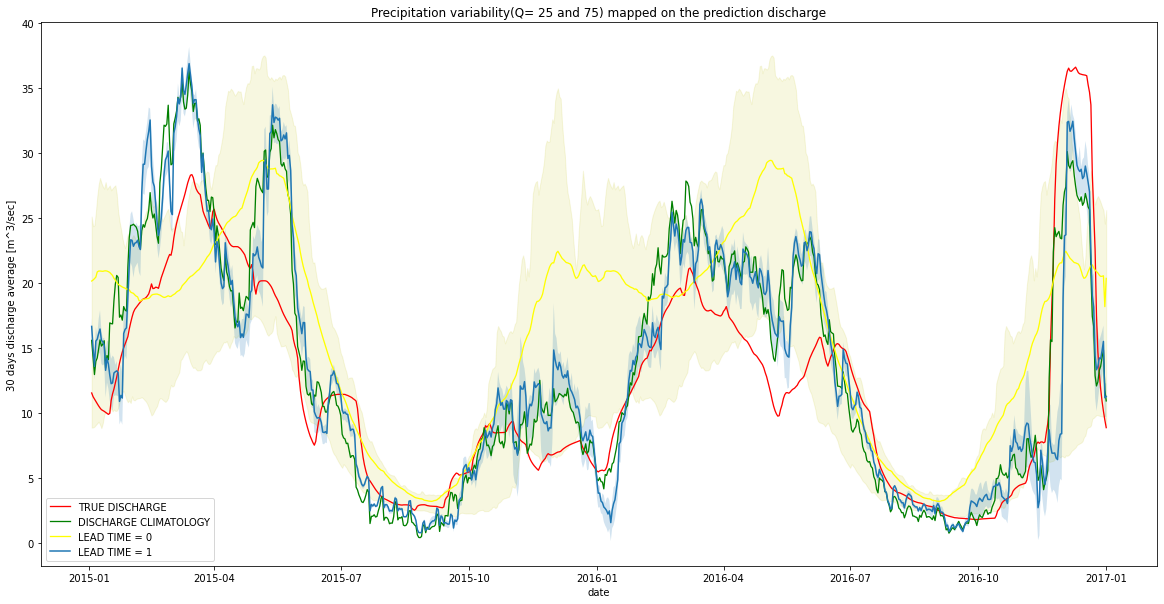

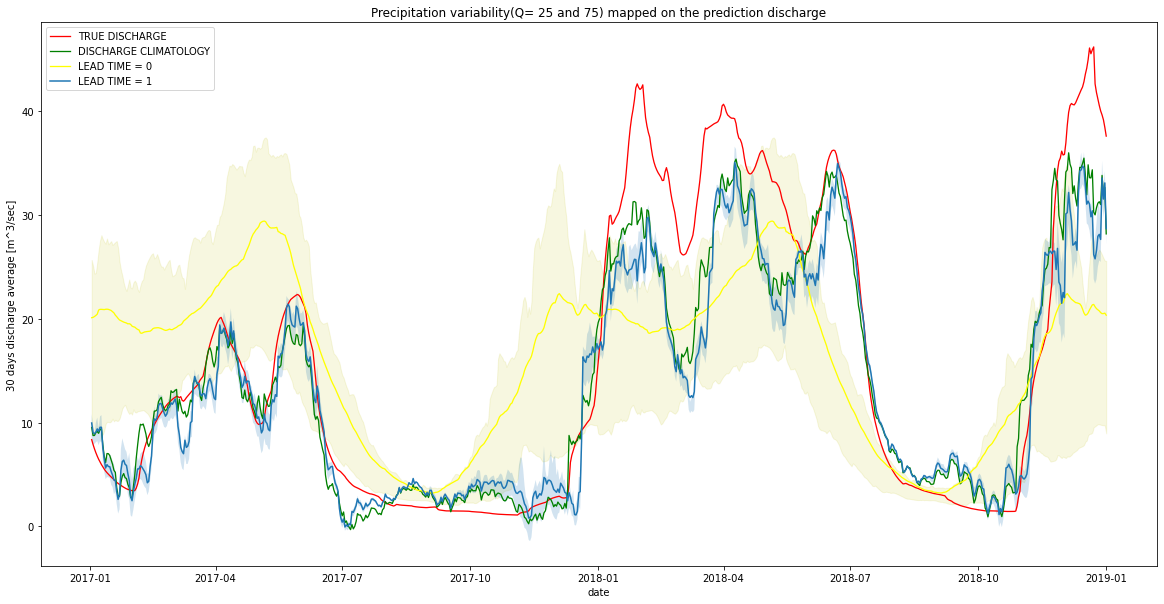

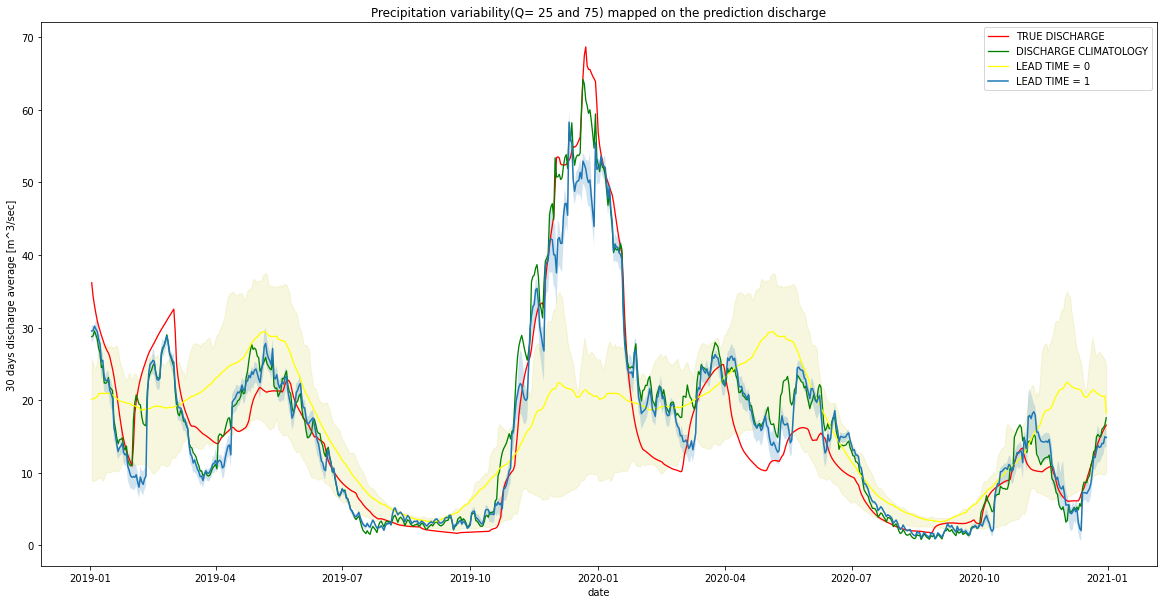

In [8]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)


measured runoff             1.000000
runoff climatology          0.332870
runoff_clim_25             -0.070560
runoff_clim_75              0.182866
model output                0.836404
output 1 month lead time    0.782682
output 2 month lead time    0.652503
output 3 month lead time    0.452408
output 4 month lead time    0.335617
output 5 month lead time    0.266597
dtype: float64

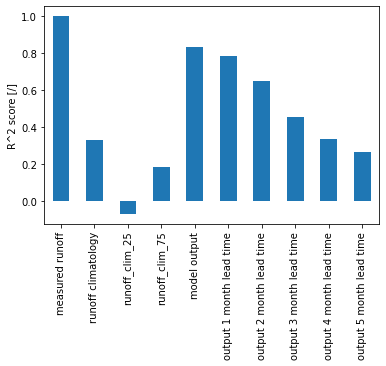

In [9]:
evaluate_prediction(predictions)

measured runoff             1.000000
runoff climatology          0.308022
runoff_clim_25             -0.027676
runoff_clim_75              0.089476
model output                0.834293
output 1 month lead time    0.758438
output 2 month lead time    0.625980
output 3 month lead time    0.422054
output 4 month lead time    0.294559
output 5 month lead time    0.213073
dtype: float64

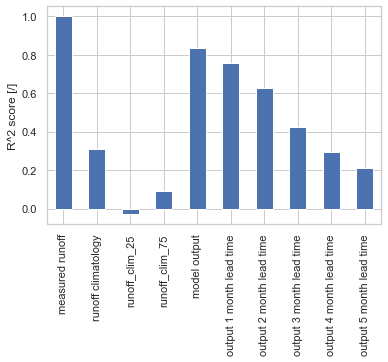

In [18]:
#old
evaluate_prediction(predictions)

In [10]:
from cross_validation_f import evaluate_class, evaluate_class_season
clas=evaluate_class_season(predictions)
clas.index=np.repeat(nb_name[:-6],4)
clas.to_csv('class_res.csv', mode='a', header=False)

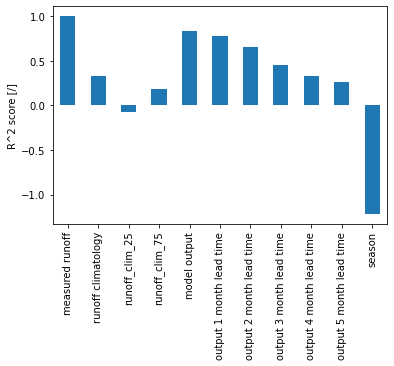

In [11]:
r=pd.DataFrame(evaluate_prediction(predictions)).transpose()
r['STAT_CODE']=(nb_name[:-6])
r.index=r.STAT_CODE
r.drop(columns=['season','runoff_clim_25','runoff_clim_75','STAT_CODE'],inplace=True)
r.to_csv('r_res.csv',mode='a',header=False)

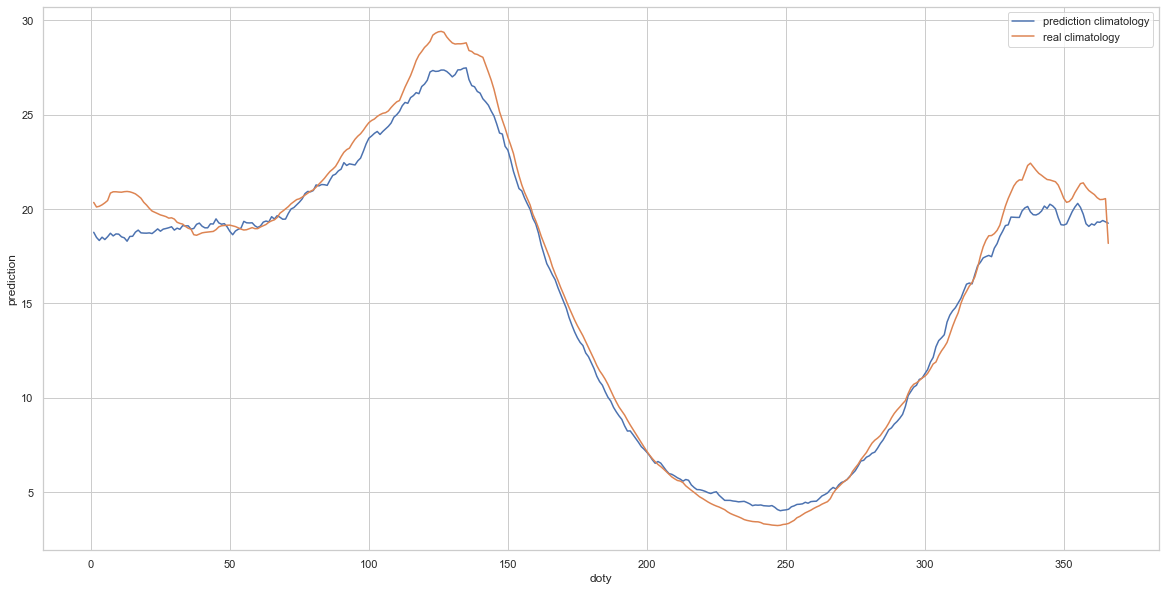

In [14]:
predictions_for_clim = classic_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits)
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index

sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

from db_insert import insert
insert(nb_name[:-6],predictions_for_clim)

In [15]:
## model savior

from sklearn.svm import SVR, LinearSVR
from base_f import create_it_matrix
from joblib import dump, load

it_matrix=create_it_matrix(daily_input,t_length,t_unit).astype('float32')

X = it_matrix.drop(columns='Q')
y = it_matrix['Q']
svr_estimator = SVR(kernel='rbf', gamma='scale', cache_size=15000,C=C,epsilon=eps)

svr_estimator = make_pipeline(StandardScaler(),
                              TransformedTargetRegressor(regressor=svr_estimator, transformer=StandardScaler()))

svr_estimator.fit(X, y)

path='models/'+nb_name[:-6]+'.joblib'

dump(svr_estimator, path)

['models/ADO_DSC_FRK2_0041.joblib']